In [183]:
import sqlite3
import os
import pandas as pd
import re

In [184]:
!pip install langchain_community

In [185]:
from langchain_community.utilities import SQLDatabase

def infer_sqlite_type(dtype):
    """Map pandas dtypes to SQLite types."""
    if pd.api.types.is_integer_dtype(dtype):
        return "INTEGER"
    elif pd.api.types.is_float_dtype(dtype):
        return "REAL"
    elif pd.api.types.is_bool_dtype(dtype):
        return "BOOLEAN"
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return "TEXT"  # Store dates as ISO strings
    else:
        return "TEXT"

def upload_csv_to_sqlite(db_path, table_name, csv_path):
    """Automatically creates a table and uploads CSV data to SQLite."""
    # Read CSV file
    df = pd.read_csv(csv_file)

    # Infer column types
    column_types = {col: infer_sqlite_type(df[col]) for col in df.columns}

    # Generate CREATE TABLE statement
    create_table_sql = f"CREATE TABLE IF NOT EXISTS {table_name} ("
    create_table_sql += ", ".join(f'"{col}" {col_type}' for col, col_type in column_types.items())
    create_table_sql += ");"

    # Connect to SQLite
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Create table dynamically
    cursor.execute(create_table_sql)
    conn.commit()

    # Insert data into the table
    df.to_sql(table_name, conn, if_exists="append", index=False)
    conn.commit()  # Ensure data is saved

    print(f" Successfully uploaded {csv_path} into table '{table_name}' in {db_path}")

    conn.close()

def check_tables_in_sqlite(db_path):
    """Check if the table exists in SQLite."""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    conn.close()
    return [table[0] for table in tables]

# Example Usage
db_file = "my_database.db"
csv_file = "/content/tested.csv"
table_name = "my_table"

upload_csv_to_sqlite(db_file, table_name, csv_file)

# Verify table creation in SQLite
tables_in_db = check_tables_in_sqlite(db_file)
print("📂 Tables in SQLite:", tables_in_db)

# Load the database using LangChain
db = SQLDatabase.from_uri(f"sqlite:///{db_file}")

# Get available table names
print("🔍 LangChain detected tables:", db.get_usable_table_names())


 Successfully uploaded /content/tested.csv into table 'my_table' in my_database.db
📂 Tables in SQLite: ['my_table']
🔍 LangChain detected tables: ['my_table']


In [186]:
import os
import getpass
if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter the Groq API key")

In [187]:
os.environ["LANGSMITH_API_KEY"]=getpass.getpass("Enter Langsmith API key")
os.environ["LANGSMITH_TRACING_ENABLED"]="true"

Enter Langsmith API key··········


In [188]:
!pip install -U langchain-groq

In [189]:
os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter the Google API")

Enter the Google API··········


In [190]:
!pip install -U langchain-google-genai

In [191]:
from langchain.chat_models import init_chat_model
model1 = init_chat_model("llama3-8b-8192",model_provider="groq")
# model1 =init_chat_model("gemini-2.0-flash",model_provider = "google_genai")


In [192]:
!pip install langchain_community

In [193]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:////content/my_database.db")

In [194]:
db.dialect

'sqlite'

In [195]:
db.get_usable_table_names()

['my_table']

In [196]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
toolkit = SQLDatabaseToolkit(db=db,llm=model1)

In [197]:
tools = toolkit.get_tools()
tool_list = [tool for tool in tools]

In [198]:
for tool in tools:
  print(tool.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [199]:
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x78c0683ae410>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x78c0683ae410>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x78c0683ae410>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [200]:
query_check = [tool for tool in tools if tool.name == "sql_db_query_checker"][0]

In [201]:
query_check.invoke("""
SELECT Age AS most_common_age
FROM my_table
WHERE Survived = 0 AND Age IS NOT NULL
GROUP BY Age
ORDER BY COUNT(*) DESC
LIMIT 1;

""")

"The original query appears to be correct and doesn't contain any common mistakes."

In [230]:
sql_db_query = [tool for tool in tools if tool.name =="sql_db_query"][0]

In [231]:
db_schema =  db.get_table_info()

In [204]:
print(db_schema)


CREATE TABLE my_table (
	"PassengerId" INTEGER, 
	"Survived" INTEGER, 
	"Pclass" INTEGER, 
	"Name" TEXT, 
	"Sex" TEXT, 
	"Age" REAL, 
	"SibSp" INTEGER, 
	"Parch" INTEGER, 
	"Ticket" TEXT, 
	"Fare" REAL, 
	"Cabin" TEXT, 
	"Embarked" TEXT
)

/*
3 rows from my_table table:
PassengerId	Survived	Pclass	Name	Sex	Age	SibSp	Parch	Ticket	Fare	Cabin	Embarked
892	0	3	Kelly, Mr. James	male	34.5	0	0	330911	7.8292	None	Q
893	1	3	Wilkes, Mrs. James (Ellen Needs)	female	47.0	1	0	363272	7.0	None	S
894	0	2	Myles, Mr. Thomas Francis	male	62.0	0	0	240276	9.6875	None	Q
*/


In [205]:
sql_db_query.invoke("""
SELECT Pclass, AVG(Fare) FROM my_table GROUP BY Pclass
""")

'[(1, 94.28029719626169), (2, 22.20210430107527), (3, 12.459677880184334)]'

In [206]:
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder

In [207]:
!pip install langgraph

In [208]:
from langgraph.graph import StateGraph,START,END,add_messages
from langchain_core.messages import AnyMessage,AIMessage,HumanMessage
from typing import TypedDict,List,Annotated
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain

In [209]:
class State(TypedDict):
  messages:Annotated[list[AnyMessage],add_messages]

In [210]:
!pip install -U langchain-google-genai




In [211]:
# sql_prompt = PromptTemplate(
#         input_variables=["question", "schema"],
#         template="""
#         You are an AI that converts natural language questions into SQL queries.
#         Ensure the SQL query only uses columns from the provided schema.

#         Database Schema:
#         {schema}

#         Question: {question}
#         SQL Query:
#         Only return the SQL query with no explanation.
#         """
#     )
# model1 =init_chat_model("Mixtral-8x7b-32768",model_provider="groq")
# sql_chain = LLMChain(llm=model1, prompt=sql_prompt)

In [212]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

sql_prompt = PromptTemplate(
    input_variables=["question", "schema"],
    template="""
    You are an AI that converts natural language questions into SQL queries.
    Ensure the SQL query only uses columns from the provided schema.

    Database Schema:
    {schema}

    Question: {question}

    Respond **only** with a valid JSON object containing the SQL query. Do not include explanations, notes, or any extra text.

    JSON Output Format:
    {{
        "sql_query": "<SQL_QUERY_HERE>"
    }}
    """
)

model1 = init_chat_model("Mixtral-8x7b-32768", model_provider="groq")
sql_chain = LLMChain(llm=model1, prompt=sql_prompt)


In [348]:
def convert_to_sql(state: State) -> State:
    user_question = state["messages"][-1].content
    sql_query = sql_chain.run({"question": user_question, "schema": db_schema}).strip()
    sql_query = sql_query.replace("\\_", "_")  # Fix escaped underscores
    sql_query = re.sub(r"\\([^\w])", r"\1", sql_query)  # Remove backslashes before non-word characters
    # print(sql_query,"converted_query")
    return {
        "messages": state["messages"] + [AIMessage(content=sql_query)]
    }



In [358]:
import json
import re

def Execute_query(state: State) -> State:
    query_content = state["messages"][-1].content # Clean up formatting
    query_content = re.sub(r"^```json\s*|\s*```$", "", query_content.strip(), flags=re.IGNORECASE)

    try:
        # Try to parse JSON if the query is wrapped in JSON format
        query_dict = json.loads(query_content)
        query = query_dict.get("sql_query", "").strip()
    except json.JSONDecodeError:
        # If JSON parsing fails, assume it's already a plain SQL string
        query = query_content.strip()

    # Ensure query is properly formatted (removing unwanted escape sequences)
    query = query.replace("\\_", "_")  # Fix escaped underscores
    query = re.sub(r"\\([^\w])", r"\1", query)  # Remove unnecessary backslashes

    # print("Executing Query:", query)  # Debugging
    print(state)
    try:
        # Execute the SQL query and handle exceptions
        result = db.run(query)
    except Exception as e:
        result = f"SQL Execution Error: {str(e)}"

    return {
        "messages": state["messages"] + [AIMessage(content=str(result))]
    }


In [269]:
sql_db_query.invoke("""
SELECT CAST(SUM(CASE WHEN Survived = 1 THEN 1 ELSE 0 END) AS REAL) * 100 / COUNT(*) FROM my_table WHERE Age > 40



""")

'[(38.96103896103896,)]'

In [216]:
# def Execute_query(state:State)->State:
#   query = state["messages"][-1].content
#   query = query.strip("`\n ")
#   print("Execute_query")
#   # result=sql_db_query.invoke(query)
#   result = db.run(query)
#   return {
#         "messages": state["messages"] + [AIMessage(content=result)]
#     }



In [217]:
# import json
# import string
# def Execute_query(state: State) -> State:
#     query_content = state["messages"][-1].content.strip("`\n ")  # Clean extra characters

#     try:
#         # Extract SQL from JSON format
#         query_dict = json.loads(query_content)  # Convert JSON string to Python dict
#         query = query_dict.get("sql_query", "").strip()  # Get the actual SQL query
#     except json.JSONDecodeError:
#         # If JSON parsing fails, assume it's already plain SQL
#         query = query_content.strip()

#     print("Executing Query:", string(query))  # Debugging

#     # Execute the cleaned SQL query
#     result = db.run(query)  # Make sure 'db.run()' is properly handling SQL execution

#     return {
#         "messages": state["messages"] + [AIMessage(content=str(result))]
#     }


In [277]:
def correct_sql_syntax_node(state: State) -> State:
    # Extract the query from the state, e.g. from the last message
    query = state["messages"][-1].content

    # global model  # or however your model is available
    model3 = init_chat_model("gemini-2.0-flash",model_provider = "google_genai")
    # Call correct_sql_syntax with the extracted query and the model
    corrected_response = correct_sql_syntax(query, model3)
    return {"messages": state["messages"] + [AIMessage(content=corrected_response)]}

In [284]:
def correct_sql_syntax(query: str, model) -> str:
    """
    Analyze the provided SQL query for syntax errors and logical mistakes, then output a corrected version.

    Args:
        query (str): The SQL query to analyze.
        model: An initialized LLM (e.g., using init_chat_model) that supports our prompt.

    Returns:
        str: The analysis and corrected SQL query as generated by the LLM.
    """
    # Define the prompt template that instructs the LLM as an expert in SQLite3 and SQLAlchemy.
    prompt_template = PromptTemplate(
        input_variables=["query"],
        template="""
            You are an expert in SQL and also in all the dialects of SQL. Your task is to analyze the following SQL query, identify any syntax errors or logical mistakes, and provide a corrected version of the query.
            Begin by listing the errors you found and explaining your corrections briefly, then output the corrected SQL query.

            SQL Query:
            {query}
           """
    )

    # Create an LLM chain using the provided model and the prompt template.
    chain = LLMChain(llm=model, prompt=prompt_template)

    # Run the chain with the query as input.
    response = chain.run({"query": query})
    return response


In [219]:
# def correct_sql_syntax_node(state: State) -> State:
#     # Extract the query from the state, e.g. from the last message
#     query = state["messages"][-1].content
#     print("syntax")
#     # global model  # or however your model is available
#     model3 = init_chat_model("gemini-2.0-flash",model_provider = "google_genai")
#     # Call correct_sql_syntax with the extracted query and the model
#     corrected_response = correct_sql_syntax(query, model3)
#     return {"messages": state["messages"] + [AIMessage(content=corrected_response)]}


In [220]:
# def correct_sql_logic(query:str,question:str,output: str, model)->str:
#    verification_prompt = PromptTemplate(
#         input_variables=["question", "sql_query"],
#         template="""
# You are an expert in SQL query generation and are familiar with all SQL dialects and their syntax. Your task is to evaluate a SQL query generated by an LLM to determine if it correctly answers the user's English question. You will be provided with:

# 1. The user's English question.
# 2. The SQL query generated by the model.
# 3. The output produced by executing that SQL query.

# Please analyze the following:

# - Does the SQL query logically address the user's question, including correct handling of aggregations such as mode and median?
# - Are there any syntax, logical, or operational errors in the query?
# - Does the output match what would be expected from a correct answer?

# If the query is correct, return only the answer along with the SQL query, with no additional text.
# If the query is incorrect, briefly list the issues and then provide only the corrected SQL query without any extra explanation.

# English Question:
# {question}

# SQL Query:
# {sql_query}

# Output:
# {output}

# Your analysis and, if needed, the corrected SQL query:

# """
#     )
#    chain = LLMChain(llm = model ,prompt = verification_prompt)
#    response = chain.run({"question":question,"sql_query":query,"output":output})
#    return response

In [321]:
def correct_sql_logic_node(state: State) -> State:
    """
    Extract values from the state and call correct_sql_logic with the proper arguments.

    Assumptions:
      - state["messages"][0] contains the original HumanMessage (question)
      - state["messages"][1] contains the AIMessage from convert_to_sql (generated SQL query)
      - state["messages"][2] contains the AIMessage from Execute_query (query output)
    Adjust the indices if your state structure is different.
    """
    # Extract the necessary values from the state
    question = state["messages"][0].content
    query = state["messages"][1].content


    # model4 = init_chat_model("Llama-70b-8912",model_provider="groq")
    model4 = init_chat_model("gemini-2.0-flash",model_provider = "google_genai")



    # Call your correct_sql_logic function with the extracted values
    corrected_response = correct_sql_logic(query, question, model4)

    # Append the corrected query (or analysis) as a new message to the state
    try:
        parsed_response = json.loads(corrected_response)  # Parse response
        corrected_sql = parsed_response.get("sql_query", "").strip()  # Extract SQL query only
    except json.JSONDecodeError:
        corrected_sql = corrected_response.strip()  # If not JSON, return as is
    # print("Logical",corrected_sql)
    return {"messages": state["messages"] + [AIMessage(content=corrected_sql)]}


In [322]:
def correct_sql_logic(query: str, question: str, model) -> str:
    verification_prompt = PromptTemplate(
        input_variables=["question", "sql_query"],
        template="""
You are an expert SQL validator. Your task is to verify whether the given SQL query correctly answers the user's question.

User Prompt:
{question}

AI-Generated SQL Query:
{sql_query}

Instructions:
- If the SQL query is in JSON format, extract only the SQL query from the "sql_query" field.
- If the SQL query is correct, return it in **exactly** the same format without any modifications.
- If the SQL query is incorrect or needs improvement, return **only** the corrected SQL query in the following JSON format, with no explanations or extra text:

{{
    "sql_query": "<UPDATED_SQL_QUERY>"
}}
"""
    )

    chain = LLMChain(llm=model, prompt=verification_prompt)
    response = chain.run({"question": question, "sql_query": query})

    # Ensure only JSON is returned without extra formatting issues
    try:
        response_json = json.loads(response)  # Parse response to ensure it's valid JSON
        return json.dumps(response_json, indent=4)  # Return formatted JSON
    except json.JSONDecodeError:
        return response.strip()  # Return raw response if not valid JSON

In [222]:
def should_continue(state: State) -> str:
    """
    Determine whether the workflow should continue to the tools node or end.

    This function inspects the last message's content. If it contains the word "Error",
    it indicates that the model encountered an issue and we want to continue processing with tools.
    Otherwise, if no error is found, we return "end" to finish the workflow.

    Args:
        state (State): The current state dictionary containing the conversation/messages.

    Returns:
        str: "continue" to branch to the tools node or "end" to finish the workflow.
    """
    last_message = state["messages"][-1].content
    if "OperationalError" in last_message:
        return "Syntax_Correction"
    else:
        return "END"



In [223]:
# def should_continue(state: State) -> str:
#     """
#     Inspects the last message from the state and decides which branch to follow:
#     - If the message contains "OperationalError", it indicates a syntax error, so return "Syntax_Correction".
#     - If the message contains "everything is correct", the query is acceptable, so return "end".
#     - Otherwise, assume there is a logical error and return "correct_sql_logic".
#     """
#     last_message = state["messages"][-1].content.lower()

#     if "operationalerror" in last_message:
#         return "Syntax_Correction"
#     # elif "everything is correct" in last_message:
#     #     return "end"
#     else:
#         # return "Logic_Correction"
#         return "END"


In [224]:
!pip install langgraph

In [359]:
workflow =StateGraph(State)

In [360]:
workflow.add_edge(START,"convert_to_sql")
workflow.add_node("convert_to_sql",convert_to_sql)
workflow.add_node("Correct_sql_logic",correct_sql_logic_node)
workflow.add_node("Correct_sql_syntax",correct_sql_syntax_node)
workflow.add_node("Execute_query",Execute_query)
# workflow.add_edge("convert_to_sql","Execute_query")
workflow.add_edge("convert_to_sql","Correct_sql_logic")
workflow.add_edge("Correct_sql_logic","Execute_query")

workflow.add_conditional_edges("Execute_query",
    should_continue,
    {
        "END":END,
        "Syntax_Correction": "Correct_sql_syntax"

    })
workflow.add_edge("Correct_sql_syntax", "Execute_query")
# workflow.add_edge("Execute_query",END)

In [361]:
app=workflow.compile()

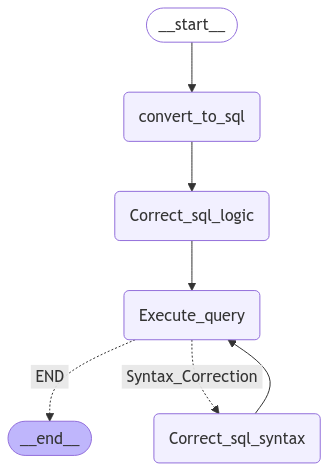

In [362]:
from IPython.display import display,Image
from langchain_core.runnables.graph import MermaidDrawMethod
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API ,
        )
    )
)


In [363]:
initial_state = {
    "messages": [HumanMessage(content="percent of people older than 40 who survived")]
}

response_state = app.invoke(initial_state)
print("Final AI Response:", response_state["messages"][-1].content)

Logical ```json
{
    "sql_query": "SELECT CAST(SUM(CASE WHEN Survived = 1 THEN 1 ELSE 0 END) AS REAL) / COUNT(*) FROM my_table WHERE Age > 40"
}
```
{'messages': [HumanMessage(content='percent of people older than 40 who survived', additional_kwargs={}, response_metadata={}, id='056cf2fa-6615-41b6-a741-9cf2fc7e35fc'), AIMessage(content='{\n    "sql_query": "SELECT COUNT(*) / CAST(SUM(Survived) AS REAL) FROM my_table WHERE Age > 40"\n}', additional_kwargs={}, response_metadata={}, id='3fecd73b-b527-4a48-8e0e-b9a4266c769d'), AIMessage(content='```json\n{\n    "sql_query": "SELECT CAST(SUM(CASE WHEN Survived = 1 THEN 1 ELSE 0 END) AS REAL) / COUNT(*) FROM my_table WHERE Age > 40"\n}\n```', additional_kwargs={}, response_metadata={}, id='4871a9c0-3f75-4f4c-ab19-4c0364680c53')]}
Final AI Response: [(0.38961038961038963,)]
